In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise_distances
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

data_path = "./dataset/datasetTC4.dat"

data = np.loadtxt(data_path)
print(data.shape)
data

(310, 6)


array([[ 63.03,  22.55,  39.61,  40.48,  98.67,  -0.25],
       [ 39.06,  10.06,  25.02,  29.  , 114.41,   4.56],
       [ 68.83,  22.22,  50.09,  46.61, 105.99,  -3.53],
       ...,
       [ 61.45,  22.69,  46.17,  38.75, 125.67,  -2.71],
       [ 45.25,   8.69,  41.58,  36.56, 118.55,   0.21],
       [ 33.84,   5.07,  36.64,  28.77, 123.95,  -0.2 ]])

In [8]:
# Normalização do dataset usando z-score
def z_score_norm(dataset):
    std = np.std(dataset, axis=0)
    normalized = (dataset - np.mean(dataset, axis=0)) / np.where(std == 0, 1e-9, std) # Caso divisão por zero
    return normalized

data = z_score_norm(data)
data

array([[ 0.14722652,  0.50111133, -0.66512805, -0.18460234, -1.44783071,
        -0.70794606],
       [-1.24570706, -0.74889057, -1.45276272, -1.04124965, -0.26402779,
        -0.57967342],
       [ 0.48427345,  0.46808485, -0.0993699 ,  0.27282344, -0.89729467,
        -0.79541679],
       ...,
       [ 0.05541029,  0.51512256, -0.31098936, -0.31369641,  0.58283504,
        -0.77354911],
       [-0.88599664, -0.88600047, -0.55877847, -0.47711606,  0.04734096,
        -0.69567882],
       [-1.54904929, -1.24829085, -0.82546218, -1.05841244,  0.45347411,
        -0.70661266]])

In [9]:
# Inicialização dos parâmetros
Kmax = 10 # Número de protótipos
rounds = 30 # Número de rodadas
epochs = 20 # Número de iterações

In [10]:
# Implementação do Índice de Dunn, oss outros índices foram usados do Scikit-learn
def dunn_index(data, labels):
    min_intercluster_dists = np.max(pairwise_distances(data, metric='euclidean'))
    max_intracluster_dists = 0.0
    
    for cluster_label in np.unique(labels):
        cluster_points = data[labels == cluster_label]
        
        if cluster_label < len(np.unique(labels)) - 1:
            not_cluster_points = data[labels > cluster_label]
            intercluster_dists = pairwise_distances(cluster_points, not_cluster_points, metric='euclidean')
            min_intercluster_dists = min(np.min(intercluster_dists), min_intercluster_dists)
            
        intracluster_dists = pairwise_distances(cluster_points, metric='euclidean')
        max_intracluster_dists = max(np.max(intracluster_dists), max_intracluster_dists)

    return min_intercluster_dists / max_intracluster_dists

In [11]:
# Batch K-medians
def kmedians(data, proto, epochs):
    N, p = data.shape
    K = proto.shape[0]
    SSD = np.zeros(epochs)
    
    updt_proto = np.copy(proto)
    
    for epoch in range(epochs):
        dist = np.zeros((N, K))
        for t in range(N):
            dist[t, :] = np.sum(np.abs(data[t, :] - updt_proto), axis=1)
        
        cluster = np.argmin(dist, axis=1)
        SSD[epoch] = np.sum(np.min(dist, axis=1)**2)
    
        for k in range(K):
            I = np.where(cluster == k)[0]
            partition = data[I, :]
            updt_proto[k, :] = np.median(partition, axis=0)

    return updt_proto, SSD

In [12]:
best_prototypes, best_final_prototypes, best_ssds, best_dunns, best_chs, best_dbs = [], [], [], [], [], []
for K in range(2, Kmax+1):
    # Aplicando K-medianas nos dados por rodada
    rnd_prototypes, rnd_final_prototypes, rnd_ssds = [], [], []
    for rnd in range(rounds):
        idxs = np.random.choice(data.shape[0], K, replace=False) # Aleatoriedade dos protótipos
        prototypes = data[idxs, :] # Protótipos definidos
        rnd_prototypes.append(prototypes)
        
        prototypes, kmedians_SSD = kmedians(data, prototypes, epochs) # Aplicando o K-medians
        
        rnd_final_prototypes.append(prototypes)
        rnd_ssds.append(kmedians_SSD)
    
    k_best_ssd_idx = np.argmin([ssd[-1] for ssd in rnd_ssds]) # Pega o índice da rodada com menor SSD final
    
    k_best_prototypes = rnd_prototypes[k_best_ssd_idx]
    k_best_final_prototypes = rnd_final_prototypes[k_best_ssd_idx]
    k_best_ssd = rnd_ssds[k_best_ssd_idx]

    labels = np.argmin(cdist(data, k_best_final_prototypes), axis=1) # Cálcula as labels (clusters) de cada amostra
    dn_index = dunn_index(data, labels) # Índice de Dunn
    ch_index = calinski_harabasz_score(data, labels) # Índice de Calinski-Harabasz
    db_index = davies_bouldin_score(data, labels) # Índice de Davies-Bouldin

    best_prototypes.append(k_best_prototypes) # Salvando os protótipos iniciais da melhor rodada de K
    best_final_prototypes.append(k_best_final_prototypes) # Salvando os protótipos finais da melhor rodada de K
    best_ssds.append(k_best_ssd) # Salvando a curva de SSD da melhor rodada de K
    best_dunns.append(dn_index) # Salvando o Índice de Dunn de K
    best_chs.append(ch_index) # Salvando o Índice de Calinski-Harabasz de K
    best_dbs.append(db_index) # Salvando o Índice de Davies-Bouldin de K

best_dunn_idx = np.argmax(best_dunns) # Melhor K segundo o Índice de Dunn
best_dunn = best_dunns[best_dunn_idx] # Melhor Índice de Dunn

best_ch_idx = np.argmax(best_chs) # Melhor K segundo o Índice de Calinski-Harabasz
best_ch = best_chs[best_ch_idx] # Melhor Índice de Calinski-Harabasz

best_db_idx = np.argmin(best_dbs) # Melhor K segundo o Índice de Davies-Bouldin
best_db = best_dbs[best_db_idx] # Melhor Índice de Davies-Bouldin

print("Best Dunn Index: {} (K = {})".format(best_dunn, best_dunn_idx+2))
print("Best Calinski-Harabasz Index: {} (K = {})".format(best_ch, best_ch_idx+2))
print("Best Davies-Bouldin Index: {} (K = {})".format(best_db, best_db_idx+2))

Best Dunn Index: 0.03602784508627102 (K = 10)
Best Calinski-Harabasz Index: 185.8456555773498 (K = 2)
Best Davies-Bouldin Index: 1.1320506184425543 (K = 2)


Best K (using Calinski-Harabasz) = 2
Best SSD = 4594.9188317103235


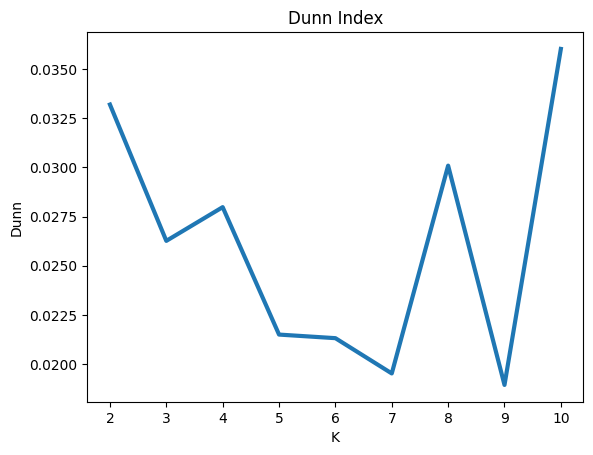

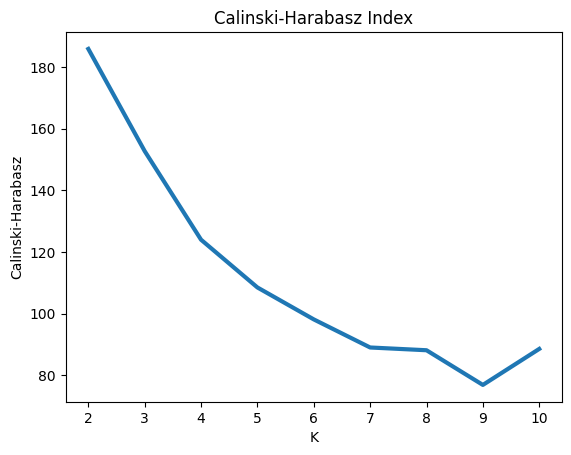

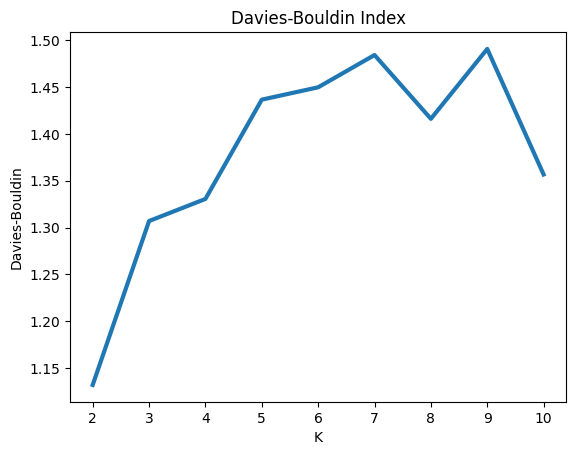

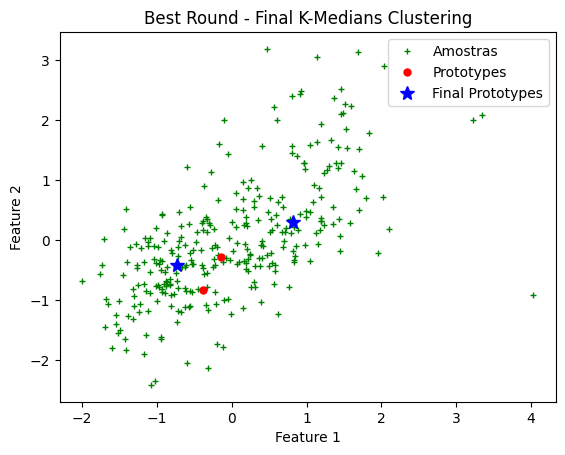

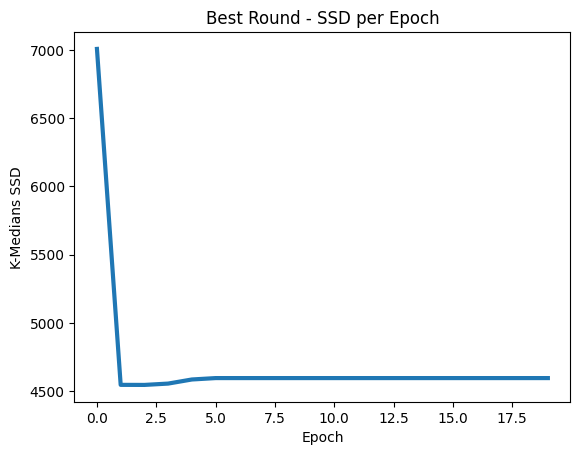

In [13]:
# Usando o Melhor K segundo o Índice de Calinski-Harabasz
best_index_prototypes = best_prototypes[best_ch_idx]
best_index_final_prototypes = best_final_prototypes[best_ch_idx]
best_index_ssd = best_ssds[best_ch_idx]

print("Best K (using Calinski-Harabasz) =", best_ch_idx+2)
print("Best SSD =", best_index_ssd[-1])

# Mostra a curva de Dunn x K
plt.figure()
plt.plot(range(2,Kmax+1), best_dunns, linewidth=3)
plt.xlabel('K')
plt.ylabel('Dunn')
plt.title('Dunn Index')
plt.show()

# Mostra a curva de CH x K
plt.figure()
plt.plot(range(2,Kmax+1), best_chs, linewidth=3)
plt.xlabel('K')
plt.ylabel('Calinski-Harabasz')
plt.title('Calinski-Harabasz Index')
plt.show()

# Mostra a curva de DB x K
plt.figure()
plt.plot(range(2,Kmax+1), best_dbs, linewidth=3)
plt.xlabel('K')
plt.ylabel('Davies-Bouldin')
plt.title('Davies-Bouldin Index')
plt.show()

# Mostra posição final dos protótipos
plt.figure()
# vor = Voronoi(kmedians_prototypes[:,:2])
# fig = voronoi_plot_2d(vor)
plt.plot(data[:, 0], data[:, 1], '+g', markersize=5)
plt.plot(best_index_prototypes[:, 0], best_index_prototypes[:, 1], '.r', markersize=10)
plt.plot(best_index_final_prototypes[:, 0], best_index_final_prototypes[:, 1], 'b*', markersize=10)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Best Round - Final K-Medians Clustering')
plt.legend(['Amostras', 'Prototypes', 'Final Prototypes'])
plt.show()

# Mostra evolução do SSD ao longo das épocas de treinamento
plt.figure()
plt.plot(best_index_ssd, linewidth=3)
plt.xlabel('Epoch')
plt.ylabel('K-Medians SSD')
plt.title('Best Round - SSD per Epoch')
plt.show()